In [1]:
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
import pickle
import numpy as np
import tensorflow as tf
import seaborn as sn
import pandas as pd
import math
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from helpers import convert_to_onehot

BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100
class_names = ['neutralne', 'oczekiwanie', 'podziw', 'radosc', 'smutek', 'strach', 'wstret', 'zaskoczenie', 'zlosc']

## Get train and test datasets and process them to be TF Dataset objects

In [2]:
# with open('../data/embeddings.pickle', 'rb') as handle:
#     train = pickle.load(handle)
    
# with open('../data/test_embedding.pickle', 'rb') as handle:
#     test = pickle.load(handle)
    
with open('../data/train.pickle', 'rb') as handle:
    org_train_X, org_train_y = pickle.load(handle)

with open('../data/test.pickle', 'rb') as handle:
    org_test_X, org_test_y = pickle.load(handle)
    
with open('../data/slowosiec_train.pickle', 'rb') as handle:
    org_train_X, org_train_y = pickle.load(handle)

# with open('../data/slowosiec_test.pickle', 'rb') as handle:
#     org_test_X, org_test_y = pickle.load(handle)
    
def is_neutral(idx):
#     print(idx, type(org_test_y[idx]), type(convert_to_onehot('neutralne')))
    return np.all([org_test_y[idx] == np.array(convert_to_onehot('neutralne'))])
    
# train_X = np.array([data[0][0] for data in train])
# train_y = np.array([convert_to_onehot(data[1]) for data in train])
# test_X = np.array([data for idx, data in enumerate(org_test_X) if not is_neutral(idx)])
# test_y = np.array([data for idx, data in enumerate(org_test_y) if not is_neutral(idx)])
# test_X = np.array([data[0].numpy()[0] for data in test])
# test_y = np.array([convert_to_onehot(data[1]) for data in test])
train_X = np.array(org_train_X)
train_y = np.array(org_train_y)
test_X = np.array(org_test_X)
test_y = np.array(org_test_y)

print(train_X.shape)
print(train_y.shape)
print(test_X.shape)
print(test_y.shape)

(64260, 768)
(64260, 9)
(843, 768)
(843, 9)


In [3]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_X, train_y))
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_X, test_y))
test_dataset = test_dataset.batch(BATCH_SIZE)

## Define 2 layer model with dropout

Train with RMSprop as an optimizer because it works better with momentum.

In [6]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=(768,)),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(9, activation="softmax", name="predictions")
])
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    0.001, decay_steps=1000, decay_rate=0.96, staircase=True
)
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=lr_schedule, rho=0.9, momentum=0.1),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['categorical_accuracy'])
model.fit(train_dataset, epochs=10)

Epoch 1/10
1005/1005 [==============================] - 4s 4ms/step - loss: 1.5512 - categorical_accuracy: 0.3646
Epoch 2/10
1005/1005 [==============================] - 4s 4ms/step - loss: 1.4682 - categorical_accuracy: 0.3907
Epoch 3/10
1005/1005 [==============================] - 4s 4ms/step - loss: 1.4534 - categorical_accuracy: 0.3955
Epoch 4/10
1005/1005 [==============================] - 4s 4ms/step - loss: 1.4454 - categorical_accuracy: 0.3975
Epoch 5/10
1005/1005 [==============================] - 4s 4ms/step - loss: 1.4390 - categorical_accuracy: 0.3996
Epoch 6/10
1005/1005 [==============================] - 4s 4ms/step - loss: 1.4340 - categorical_accuracy: 0.4005
Epoch 7/10
1005/1005 [==============================] - 4s 4ms/step - loss: 1.4294 - categorical_accuracy: 0.4020
Epoch 8/10
1005/1005 [==============================] - 4s 4ms/step - loss: 1.4221 - categorical_accuracy: 0.4018
Epoch 9/10
1005/1005 [==============================] - 4s 4ms/step - loss: 1.4180 - cat

## Get model schema

In [7]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 256)               196864    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
predictions (Dense)          (None, 9)                 1161      
Total params: 230,921
Trainable params: 230,921
Non-trainable params: 0
_________________________________________________________________


## Make predictions on test dataset and calculate classification metrics

In [8]:
raw_data = model.predict(test_dataset)
predictions = np.argmax(raw_data, axis=-1)
true_y = np.argmax(test_y, axis=-1)
true_y[0]

2

In [9]:
print(classification_report(true_y, predictions, target_names=class_names))

              precision    recall  f1-score   support

   neutralne       0.00      0.00      0.00       518
 oczekiwanie       0.00      0.00      0.00        28
      podziw       0.02      0.02      0.02        52
      radosc       0.12      0.88      0.20        83
      smutek       0.08      0.05      0.06        20
      strach       0.00      0.00      0.00        13
      wstret       0.00      0.00      0.00        24
 zaskoczenie       0.00      0.00      0.00        12
       zlosc       0.33      0.46      0.38        93

    accuracy                           0.14       843
   macro avg       0.06      0.16      0.07       843
weighted avg       0.05      0.14      0.06       843



/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Check missed predictions

In [10]:
miss_class = (predictions != true_y).nonzero()[0]

In [11]:
miss_class[:15]

array([ 0,  2,  3,  4,  8,  9, 10, 11, 12, 14, 15, 16, 17, 18, 19])

In [12]:
## get original texts instead of embedded vectors
with open('../data/slowosiec_test_org.pickle', 'rb') as handle:
    test_X_org = pickle.load(handle)

In [13]:
for idx in miss_class[:15]:
    print(f"Predicted: {class_names[predictions[idx]]}, Acc label: {class_names[true_y[idx]]}")
    print(raw_data[idx])
    print(test_X_org[idx])
    print()

Predicted: radosc, Acc label: podziw
[1.0919716e-09 4.2226169e-02 4.5074889e-01 4.9709457e-01 4.9222573e-03
 1.4797637e-04 1.2683751e-03 4.9473882e-05 3.5423979e-03]
Mam dostateczną ilość wody dla nas dwóch.

Predicted: radosc, Acc label: neutralne
[3.6782692e-13 4.7265995e-02 3.4835660e-01 6.0415488e-01 1.4050490e-04
 1.8521555e-07 1.7327442e-05 1.6702347e-07 6.4354586e-05]
Ogółem życie toczy nam się tutaj klawo i nie narzekamy. 

Predicted: radosc, Acc label: podziw
[9.2436840e-06 5.9999716e-02 2.9549980e-01 3.3756095e-01 1.0708824e-01
 2.6141860e-02 5.5087510e-02 6.7793345e-03 1.1183332e-01]
Zjadliwość tej starej klempy działa mi na nerwy - w końcu jej coś odpowiem tak, że się nogami nakryje. 

Predicted: radosc, Acc label: neutralne
[5.2131332e-07 7.7891998e-02 2.7533826e-01 4.3298557e-01 7.0029505e-02
 6.8588019e-03 5.1984262e-02 2.0143141e-03 8.2896829e-02]
Dzięki wyrozumiałości pani od matematyki mogłem poprawiać po raz trzeci klasówkę.

Predicted: radosc, Acc label: neutralne
[

<AxesSubplot:>

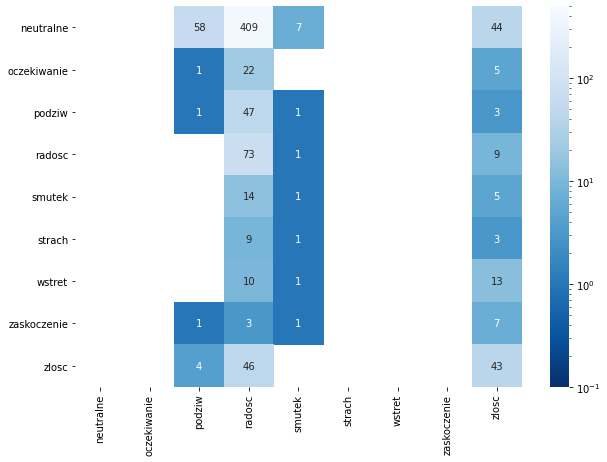

In [14]:
cm = confusion_matrix(true_y, predictions)
df_cm = pd.DataFrame(cm, index = [i for i in class_names],
                  columns = [i for i in class_names])
plt.figure(figsize = (10,7))

sn.heatmap(df_cm, cmap="Blues_r", annot=True, norm=LogNorm(vmin=0.1, vmax=500), fmt="d")

In [15]:
cm

array([[  0,   0,  58, 409,   7,   0,   0,   0,  44],
       [  0,   0,   1,  22,   0,   0,   0,   0,   5],
       [  0,   0,   1,  47,   1,   0,   0,   0,   3],
       [  0,   0,   0,  73,   1,   0,   0,   0,   9],
       [  0,   0,   0,  14,   1,   0,   0,   0,   5],
       [  0,   0,   0,   9,   1,   0,   0,   0,   3],
       [  0,   0,   0,  10,   1,   0,   0,   0,  13],
       [  0,   0,   1,   3,   1,   0,   0,   0,   7],
       [  0,   0,   4,  46,   0,   0,   0,   0,  43]])